In [130]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [131]:
# plt.style.use(['science', 'ieee'])

# Analyse server data: Throughput and CPU Usage

In [132]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).mean(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

In [133]:
def import_throughput(res_dir):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
    throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
    throughput_csv['rxpck/s'] *= 1e-6
    throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir):
    cpu_csv = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    
    cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_iperf(res_dir):
    df_t = []
    for i in range(1, 11):
        try:
            net_client_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).mean().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
        latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).mean().reset_index()
    
    return latency_df

In [134]:
colors = ['black', 'red', 'blue', 'green', 'yellow']
markers = ['x', '+', 'o', 's', 'd']

def plot_per_cpu(frame, cpu=18, client=100):
    df = frame[(frame.cpu == cpu) & (frame.client == client)]
    df.plot.bar(x='core', y='used', ylim=[0, 110],
               xlabel="CPU core", ylabel="CPU usage percentage")

def plot_ht_diff(
    df, x, y, xlabel, ylabel,
    label, color, marker,
    xlim=None, ylim=None, ax=None, ht=None, cores=18
):
    df_18 = df[df.cpu == cores].set_index(x)
    df_36 = df[df.cpu == cores * 2].set_index(x)
    
    df_diff = df_36 / df_18
    
    df_diff = df_diff.reset_index()
    
    if ax is None:
        ax = df_diff.plot(
            x=x, y=y,
            xlabel=xlabel, ylabel=ylabel,
            label=f'{label} SMT ON/OFF', 
            c=color, style='-', marker=marker,
            grid=True,
            xlim=xlim, ylim=ylim,
        )
    else:
        ax = df_diff.plot(
            x=x, y=y, ax=ax,
            xlabel=xlabel, ylabel=ylabel,
            label=f'{label} SMT ON/OFF', 
            c=color, style='-', marker=marker,
            grid=True,
            xlim=xlim, ylim=ylim,
        )
    
    return ax
    
def plot_ht(
    df, x, y, xlabel, ylabel,
    label, color, marker,
    xlim=None, ylim=None, ax=None, ht=None, cores=18
):
    df_18 = df[df.cpu == cores]
    df_36 = df[df.cpu == cores * 2]
    
    if ht is None or ht == False:
        smt = "-OFF" if ht is not False else ""
        if ax is None:
            ax = df_18.plot(
                x=x, y=y,
                xlabel=xlabel, ylabel=ylabel,
                label=f'{label}{smt}', 
                c=color, style='-', marker=marker,
                grid=True,
                xlim=xlim, ylim=ylim,
            )
        else:
            ax = df_18.plot(
                ax=ax,
                x=x, y=y,
                xlabel=xlabel, ylabel=ylabel,
                label=f'{label}{smt}', 
                c=color, style='-', marker=marker,
                xlim=xlim, ylim=ylim,
                grid=True
            )
    if ht is None or ht == True:
        smt = "-ON" if ht is not True else ""
        style = "--" if ht is not True else "-"
        ax = df_36.plot(ax=ax, 
            x=x, y=y, 
            xlabel=xlabel, ylabel=ylabel,
            label=f"{label}{smt}",
            c=color, style=style, marker=marker,
            xlim=xlim, ylim=ylim,
            grid=True)

    return ax
    
def plot_configs(
    dfs, x, y, xlabel, ylabel,
    labels, colors=colors, markers=markers,
    xlim=None, ylim=None, ht=None, cores=18, style=None
):
    ax = None
    if style == 'diff':
        for df, color, marker, label in zip(dfs, colors, markers, labels):
            ax = plot_ht_diff(df, x, y, xlabel, ylabel, label, color, marker, xlim, ylim, ax=ax, ht=ht, cores=cores)
        plt.show()
    else:
        for df, color, marker, label in zip(dfs, colors, markers, labels):
            ax = plot_ht(df, x, y, xlabel, ylabel, label, color, marker, xlim, ylim, ax=ax, ht=ht, cores=cores)
        plt.show()

In [135]:
def get_dataframes(dirs, kind=None):
    if kind is None:
        print("Possible kinds: net, net-iperf, cpu, latency")
        return

    if kind in ["net", "cpu"]:
        dfs_wg = []
        dfs_phy = []
    else:
        dfs = []
    labels = []
    for _, entry in dirs:
        if kind == "net":
            net_wg, net_phy = import_throughput(entry[0])
            dfs_wg.append(net_wg)
            dfs_phy.append(net_phy)
        elif kind == 'cpu':
            global_cpu, per_core = import_cpu(entry[0])
            dfs_wg.append(global_cpu)
            dfs_phy.append(per_core)
        elif kind == "latency":
            latency_df = import_latency(entry[0])
            dfs.append(latency_df)
        elif kind == 'net-iperf':
            df = import_iperf(entry[0])
            dfs.append(df)
        label = entry[2]
        labels.append(label)
    
    if kind in ["latency", "net-iperf"]:
        return dfs, labels
    elif kind in ["net", "cpu"]:
        return dfs_wg, dfs_phy, labels

def get_config_ids(res_dirs, wg_variant=None, config=None, flow=None, traffic=None):
    ids = []
    for idx, entry in enumerate(res_dirs):
        data = entry
        if wg_variant is not None and data[4] != wg_variant:
            continue
        if config is not None and data[2] != config:
            continue
        if flow is not None and data[3] != flow:
            continue
        if traffic is not None and data[5] != traffic:
            continue

        ids.append((idx, entry))
    return ids

In [136]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"
#     variant_path = f"../{res_dir}/EXPERIMENT_DATA/WG_VARIANT"
#     machine_path = f"../{res_dir}/EXPERIMENT_DATA/MACHINE_TYPE"
    
    with open(filename) as file:
        test_config = file.read().strip()
    
    
    if test_config != 'default':
        config, wg_variant, traffic = test_config.split('--')
        temp = config.split('__')
        if len(temp) == 2:
            config, flow = temp
        else:
            config, flow = config, '30m'
    else:
        config = wg_variant = traffic = flow = None
        
    return test_config, config, flow, wg_variant, traffic

In [137]:
res_dirs = [(e, *reslv_res_name(e)) for e in os.listdir("../") if e.startswith("results-")]

In [138]:
configs = [t[2] for t in res_dirs]
to_remove = configs.index(None)
_ = res_dirs.pop(to_remove)

In [139]:
# [e[1:3] for e in res_dirs if e[1].startswith('rss-rps')]

In [140]:
configs = ['default', 'irqbalance', 'rss', 'irqbalance-rss', 'rss-rps', 'rps']
flows = ['1g', '30m']
variants = ['wg-lkm', 'wg-go', "wg-rust"]
traffics = ['tcp', 'udp']

labels = configs

In [141]:
dirs = []
for config in configs:
    res = get_config_ids(res_dirs, traffic="udp", wg_variant="wg-lkm", config=config, flow="30m")
    if len(res) != 0:
        dirs.append(res[0])
# dirs

In [142]:
all_dirs = [k for k in enumerate(res_dirs)]

In [143]:
len(all_dirs)

76

In [144]:
df_latency, labels = get_dataframes(all_dirs, kind='latency')
df_global, df_per_core, labels = get_dataframes(all_dirs, kind='cpu')
dfs_wg, dfs_phy, labels = get_dataframes(all_dirs, kind='net')

In [145]:
wg = True

In [146]:
dfs = list(zip(df_latency, df_global, dfs_wg if wg else dfs_phy))

In [147]:
# dfs = dfs[:35] + dfs[36:]

In [148]:
# header = ['irqbalance', 'rss', 'rps', 'flow', 'variant', 'traffic']
header = ['net_config', 'flow', 'variant', 'traffic']
for config_info, dataframes in zip(res_dirs, dfs):
    config = config_info[2]
    if config is None:
        continue
    irqbl = "on" if 'irqbalance' in config else 'off'
    rss = "on" if  'rss' in config else 'off'
    rps = "on" if 'rps' in config else 'off'
    flow = config_info[3]
    variant = config_info[4]
    traffic = config_info[5]
#     config_description = [irqbl, rss, rps, flow, variant, traffic]
    config_description = [config, flow, variant, traffic]
#     print(config_description)
    for df in dataframes:
        df[header] = config_description

In [149]:
dataframes = []
for idx, df_list in enumerate(dfs):
#     print(len(df_list))
#     print(idx)
    for df in df_list:
        df.set_index(header + ['cpu', 'client'], inplace=True)
    t = pd.concat(df_list, axis=1)
#     print(t)
    dataframes.append(t)

In [150]:
dataframes = [d.drop(['run', 'node'], axis=1) for d in dataframes]
dataframes = [d.dropna() for d in dataframes]
dataframes = [d for d in dataframes if d.size != 0]

In [151]:
df_total = pd.concat(dataframes, axis=0).reset_index()

In [152]:
df_spec = {}
for traffic in ['udp', 'tcp']:
    v = {}
    for flow in ['1g', '30m']:
        v[flow] = df_total[(df_total.traffic == traffic) & (df_total.flow == flow)]
    df_spec[traffic] = v

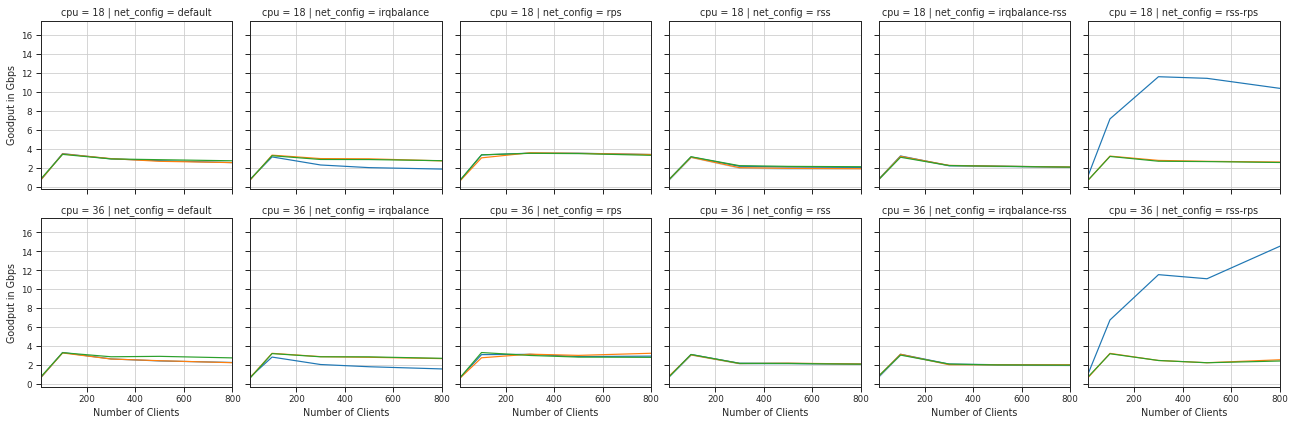

In [154]:
# with plt.style.context(['science', 'ieee']):
traffic = 'tcp'
flow = '30m'

sns.set_context("paper")
sns.set_style('ticks')
g = sns.FacetGrid(
    df_spec[traffic][flow], despine=False,
    col='net_config', row='cpu', hue='variant',
    col_order=['default', 'irqbalance', 'rps', 'rss', 'irqbalance-rss', 'rss-rps', ]
)
g.map(sns.lineplot, 'client', 'rxkB/s')
g.set(xlabel='Number of Clients')
g.set(ylabel='Goodput in Gbps')
g.set(xlim=(10, 80 if flow == '1g' else 800))
for ax in g.axes_dict.values():
    ax.grid(True)
plt.show()

In [106]:
traffic

'udp'

In [107]:
variants

['wg-lkm', 'wg-go', 'wg-rust']

In [108]:
colors = ['red', 'blue', 'black']
markers = ['x', 'o', 's']

In [109]:
def select_variant(df, variant):
    return df[df.variant == variant]

def plot_throughput(df, cpu, net_config):
    to_plot = df[(df.cpu==cpu) & (df.net_config == net_config)]
    plots = [select_variant(to_plot, variant) for variant in variants]
#     print(plots[0])
    ax = plots[0].plot.line(x='client', y='rxkB/s', c=colors[0], label=variants[0], marker='x')
    for plot_, c, m, v in zip(plots[1:], colors[1:], markers[1:], variants[1:]):
        ax = plot_.plot.line(
            ax=ax, x='client', y='rxkB/s',
            ylim=[0, 26], c=c, xlim=[10, 80 if flow == '1g' else 800], label=v, marker=m,
            xlabel='Number of Clients', ylabel='Goodput in Gbps', grid=True
        )
    plt.show()

In [110]:
# with plt.style.context(['science', 'ieee']):
#     plot_throughput(df_spec[traffic][flow], 18, 'rss-rps')

In [111]:
df_rel = df_total[df_total.client % 80 == 0]

In [112]:
df_spec_rel = {}
for traffic in ['udp', 'tcp']:
    v = {}
    for flow in ['1g', '30m']:
        v[flow] = df_rel[(df_rel.traffic == traffic) & (df_rel.flow == flow)]
    df_spec_rel[traffic] = v

In [113]:
df_spec = {}
for traffic in ['udp', 'tcp']:
    v = {}
    for flow in ['1g', '30m']:
        v[flow] = df_total[(df_total.traffic == traffic) & (df_total.flow == flow)]
    df_spec[traffic] = v

In [114]:
traffic, flow = 'tcp', '1g'

In [115]:
df_t = df_spec_rel[traffic][flow]

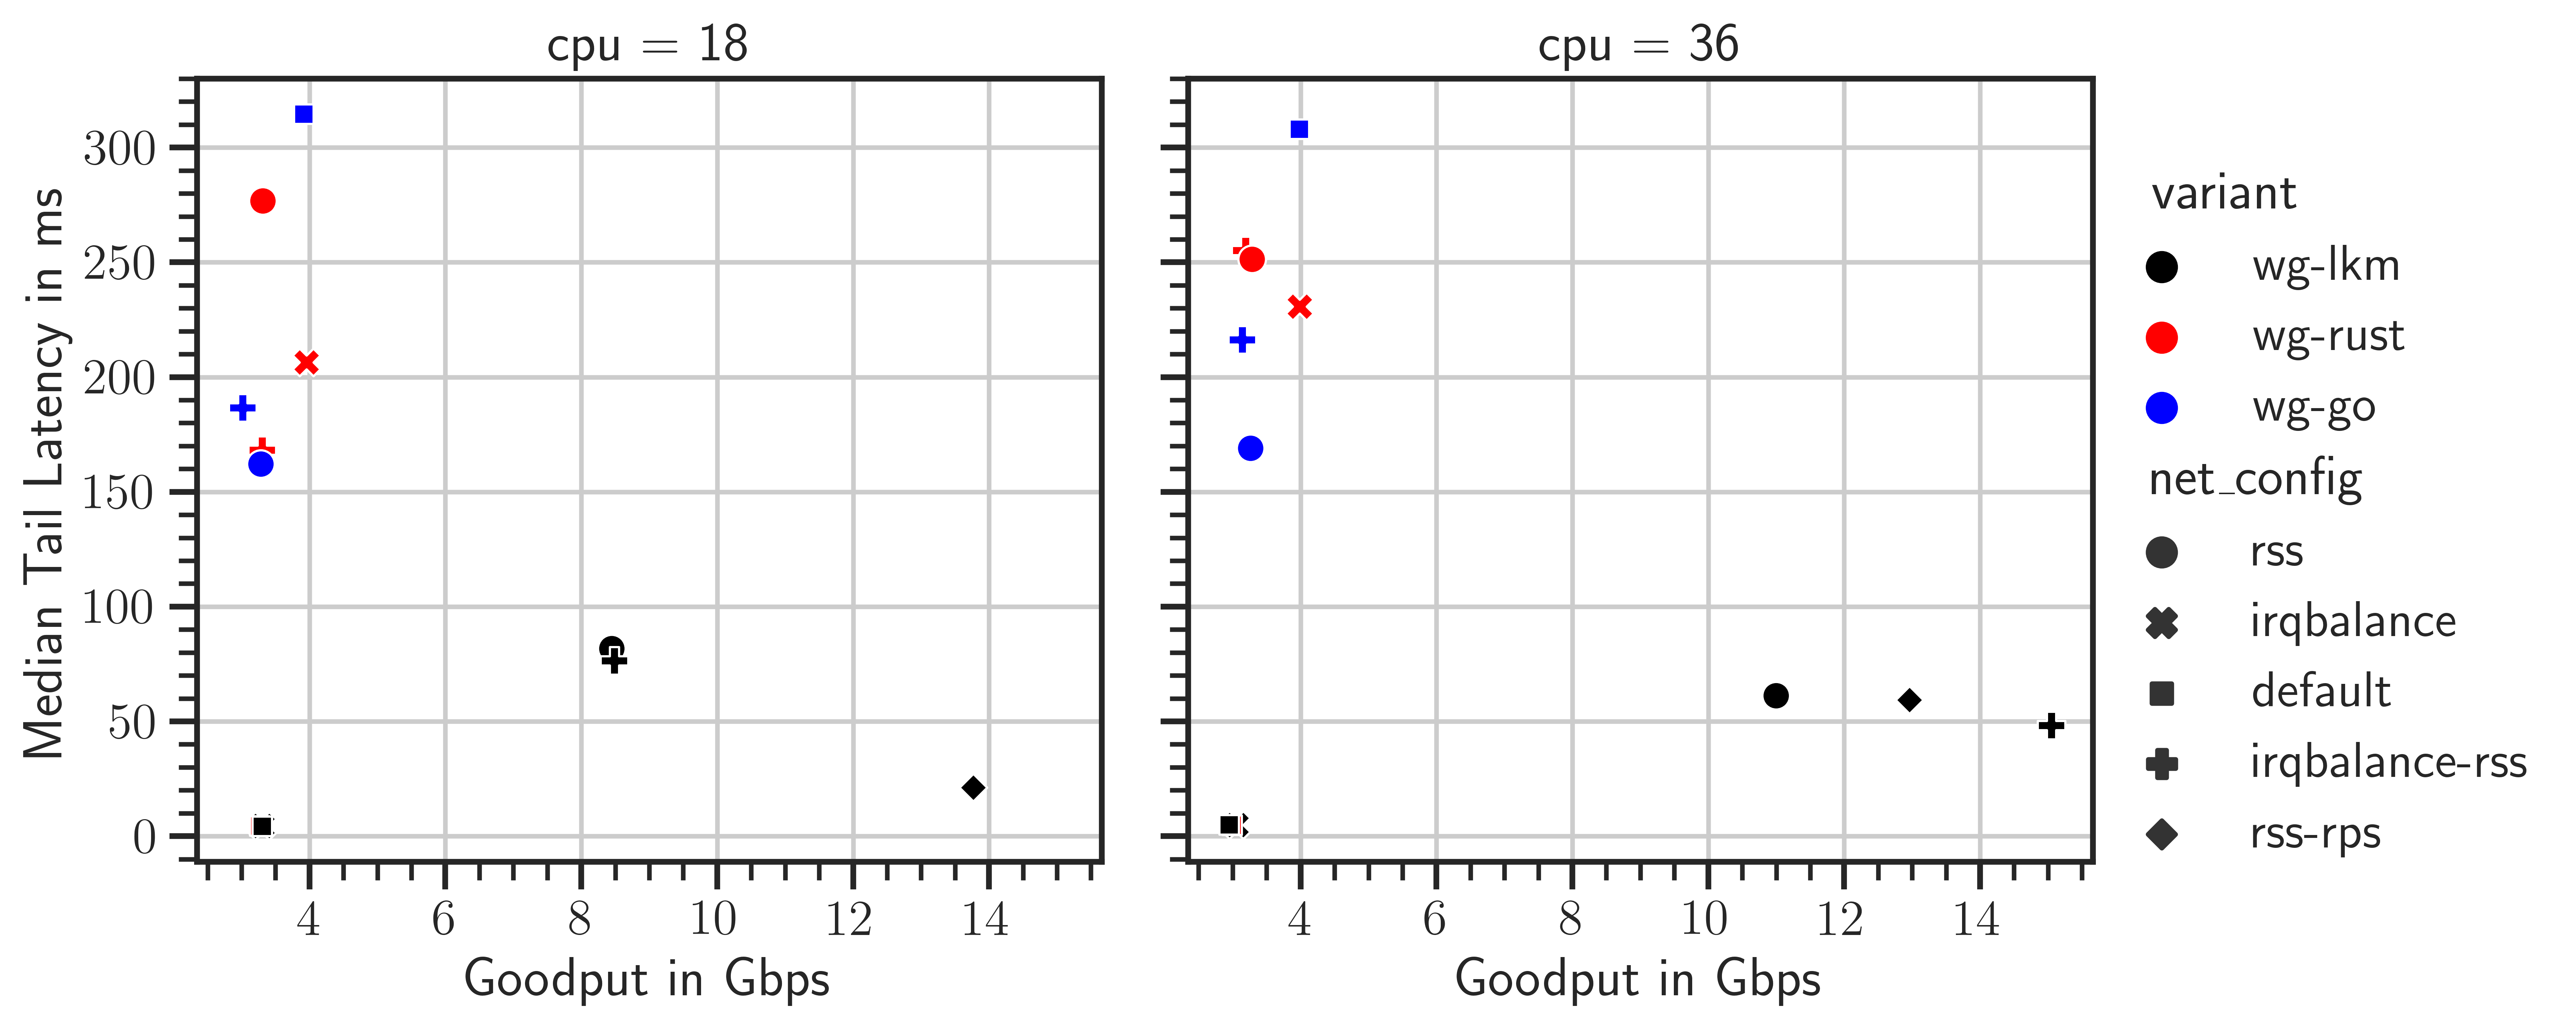

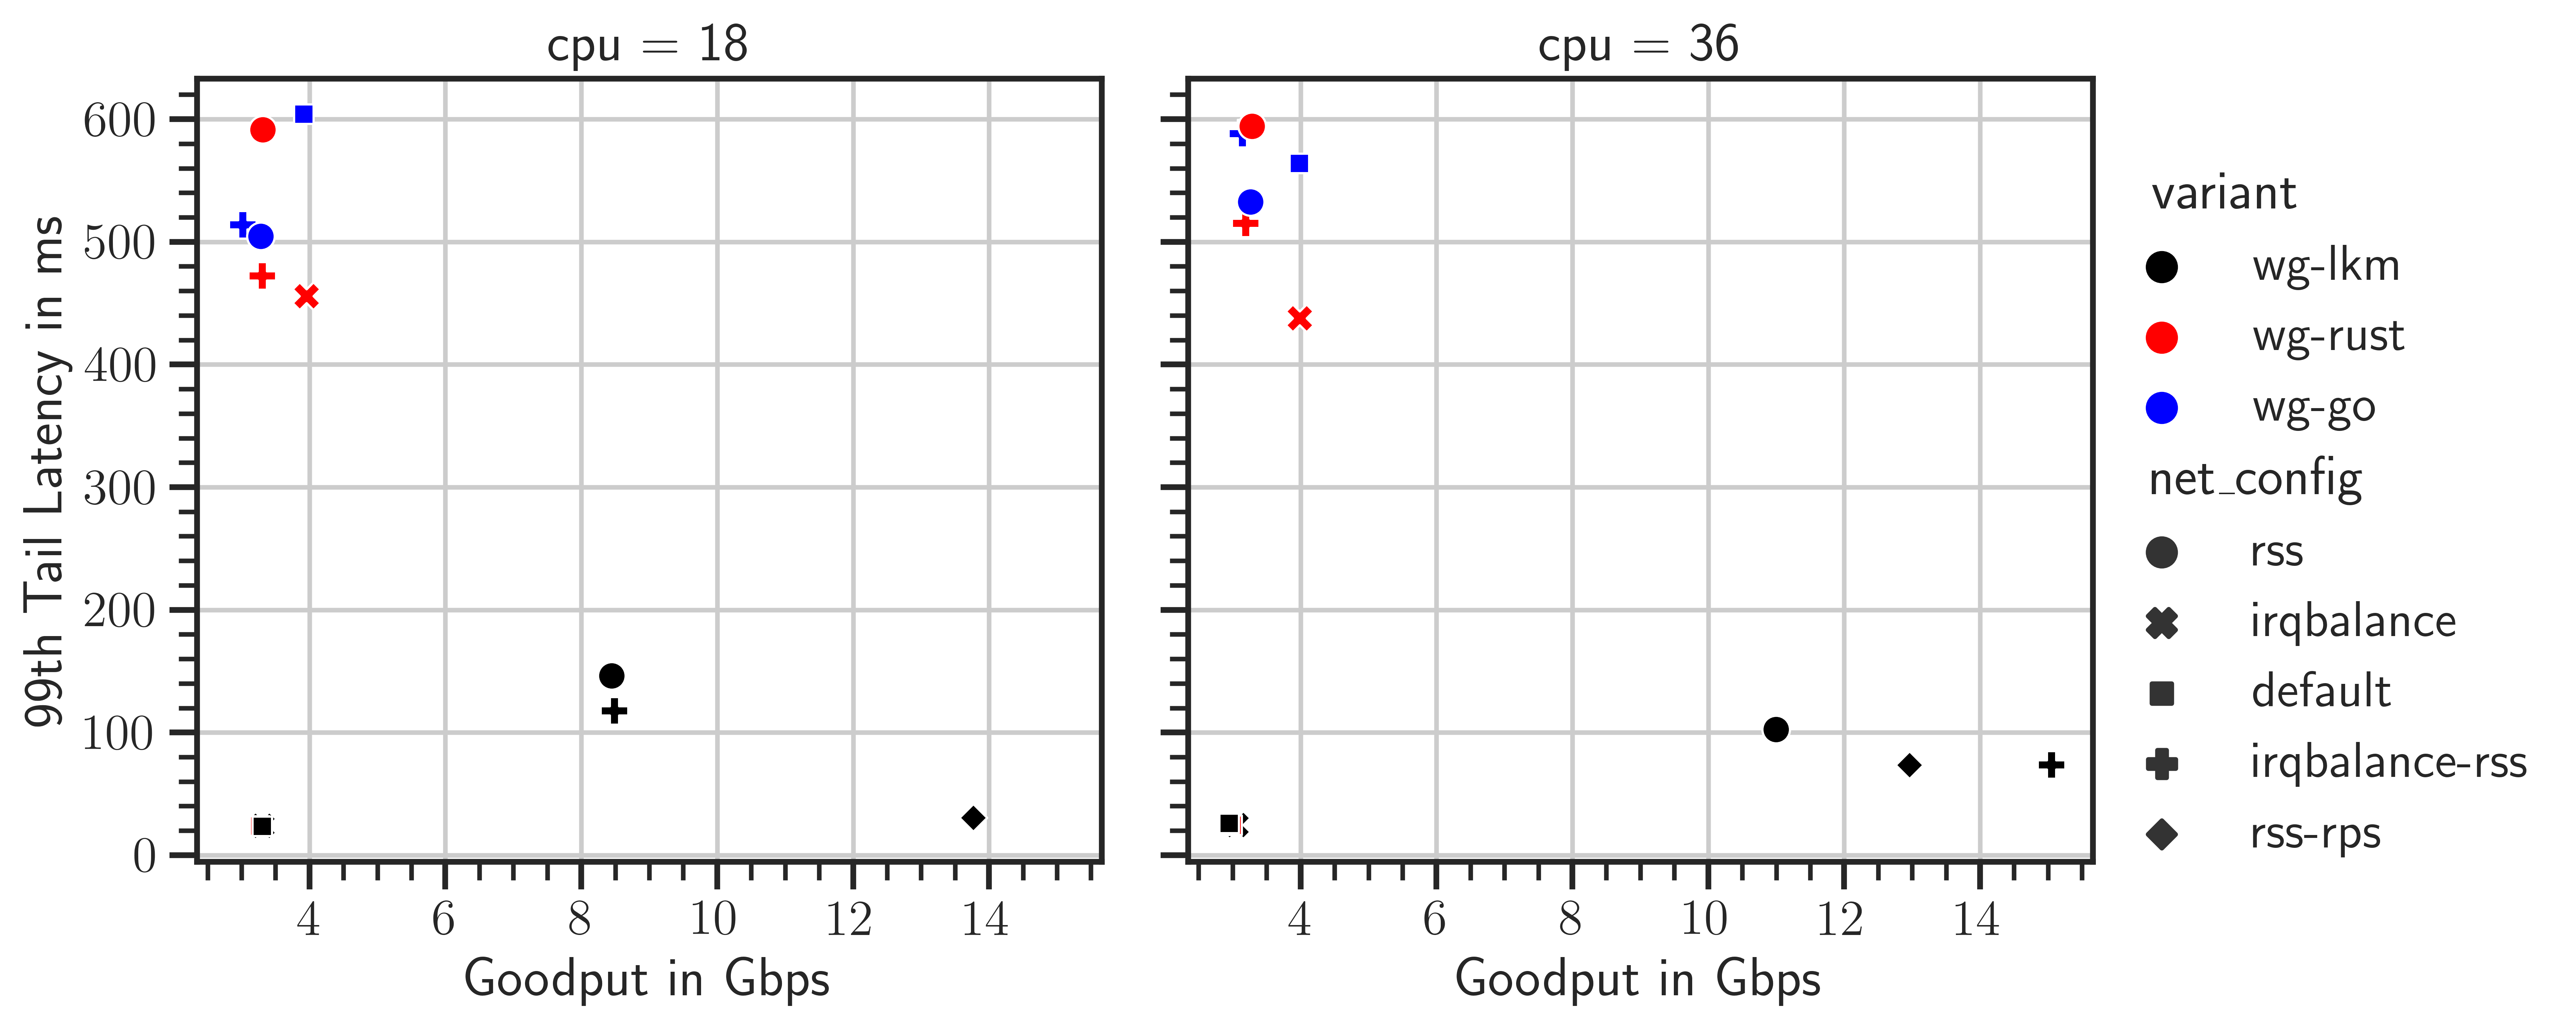

In [116]:
with plt.style.context(['science', 'ieee']):
    sns.set_context("talk")
    sns.set_style('ticks')
    g = sns.relplot(
        data=df_t, x='rxkB/s', y='median',
        hue='variant', 
#         size='cpu', size_order=[18, 36], 
        style='net_config',
        col='cpu',
        facet_kws={'despine': False}
    )
    g.set(xlabel='Goodput in Gbps')
    g.set(ylabel='Median Tail Latency in ms')
    for ax in g.axes_dict.values():
        ax.grid(True)

with plt.style.context(['science', 'ieee']):
    sns.set_context("talk")
    sns.set_style('ticks')
    g = sns.relplot(
        data=df_t, x='rxkB/s', y='99th',
        hue='variant', 
#         size='cpu', size_order=[18, 36], 
        style='net_config',
        col='cpu',
        facet_kws={'despine': False}
    )
    g.set(xlabel='Goodput in Gbps')
    g.set(ylabel='99th Tail Latency in ms')
    for ax in g.axes_dict.values():
        ax.grid(True)
    

In [117]:
df_t = df_spec_rel[traffic][flow]

In [118]:
df_tt = df_t.set_index(['net_config', 'flow', 'variant', 'traffic', 'client'])

In [119]:
# df_tt

In [120]:
df_t_off = df_tt[df_tt.cpu == 18]
df_t_on = df_tt[df_tt.cpu == 36]

In [121]:
cols = ['median', '99th', 'rxkB/s', 'txkB/s']

In [122]:
def select(df, variant, net_config):
    return df[(df.variant == variant) & (df.net_config == net_config)]
variant = 'wg-lkm'
net_config = 'rss'

In [123]:
t = df_t_on[cols] - df_t_off[cols]

In [124]:
diff_on_off = t.reset_index()

In [125]:
df_t_off = df_t_off.reset_index()
df_t_on = df_t_on.reset_index()

In [126]:
off = select(df_t_off, variant, net_config)[cols].reset_index(drop=True)
on = select(df_t_on, variant, net_config)[cols].reset_index(drop=True)

In [127]:
diff_on_off.head()

,net_config,flow,variant,traffic,client,median,99th,rxkB/s,txkB/s
0,rss,1g,wg-lkm,tcp,80,-20.528125,-43.738054,2.550113,0.011451
1,irqbalance,1g,wg-rust,tcp,80,24.307242,-18.049892,0.030804,-0.000838
2,irqbalance,1g,wg-lkm,tcp,80,0.383379,0.607412,-0.250091,-0.014698
3,default,1g,wg-rust,tcp,80,0.411371,0.644871,-0.273266,-0.016840
4,irqbalance-rss,1g,wg-rust,tcp,80,87.035962,42.941692,-0.112537,-0.002605


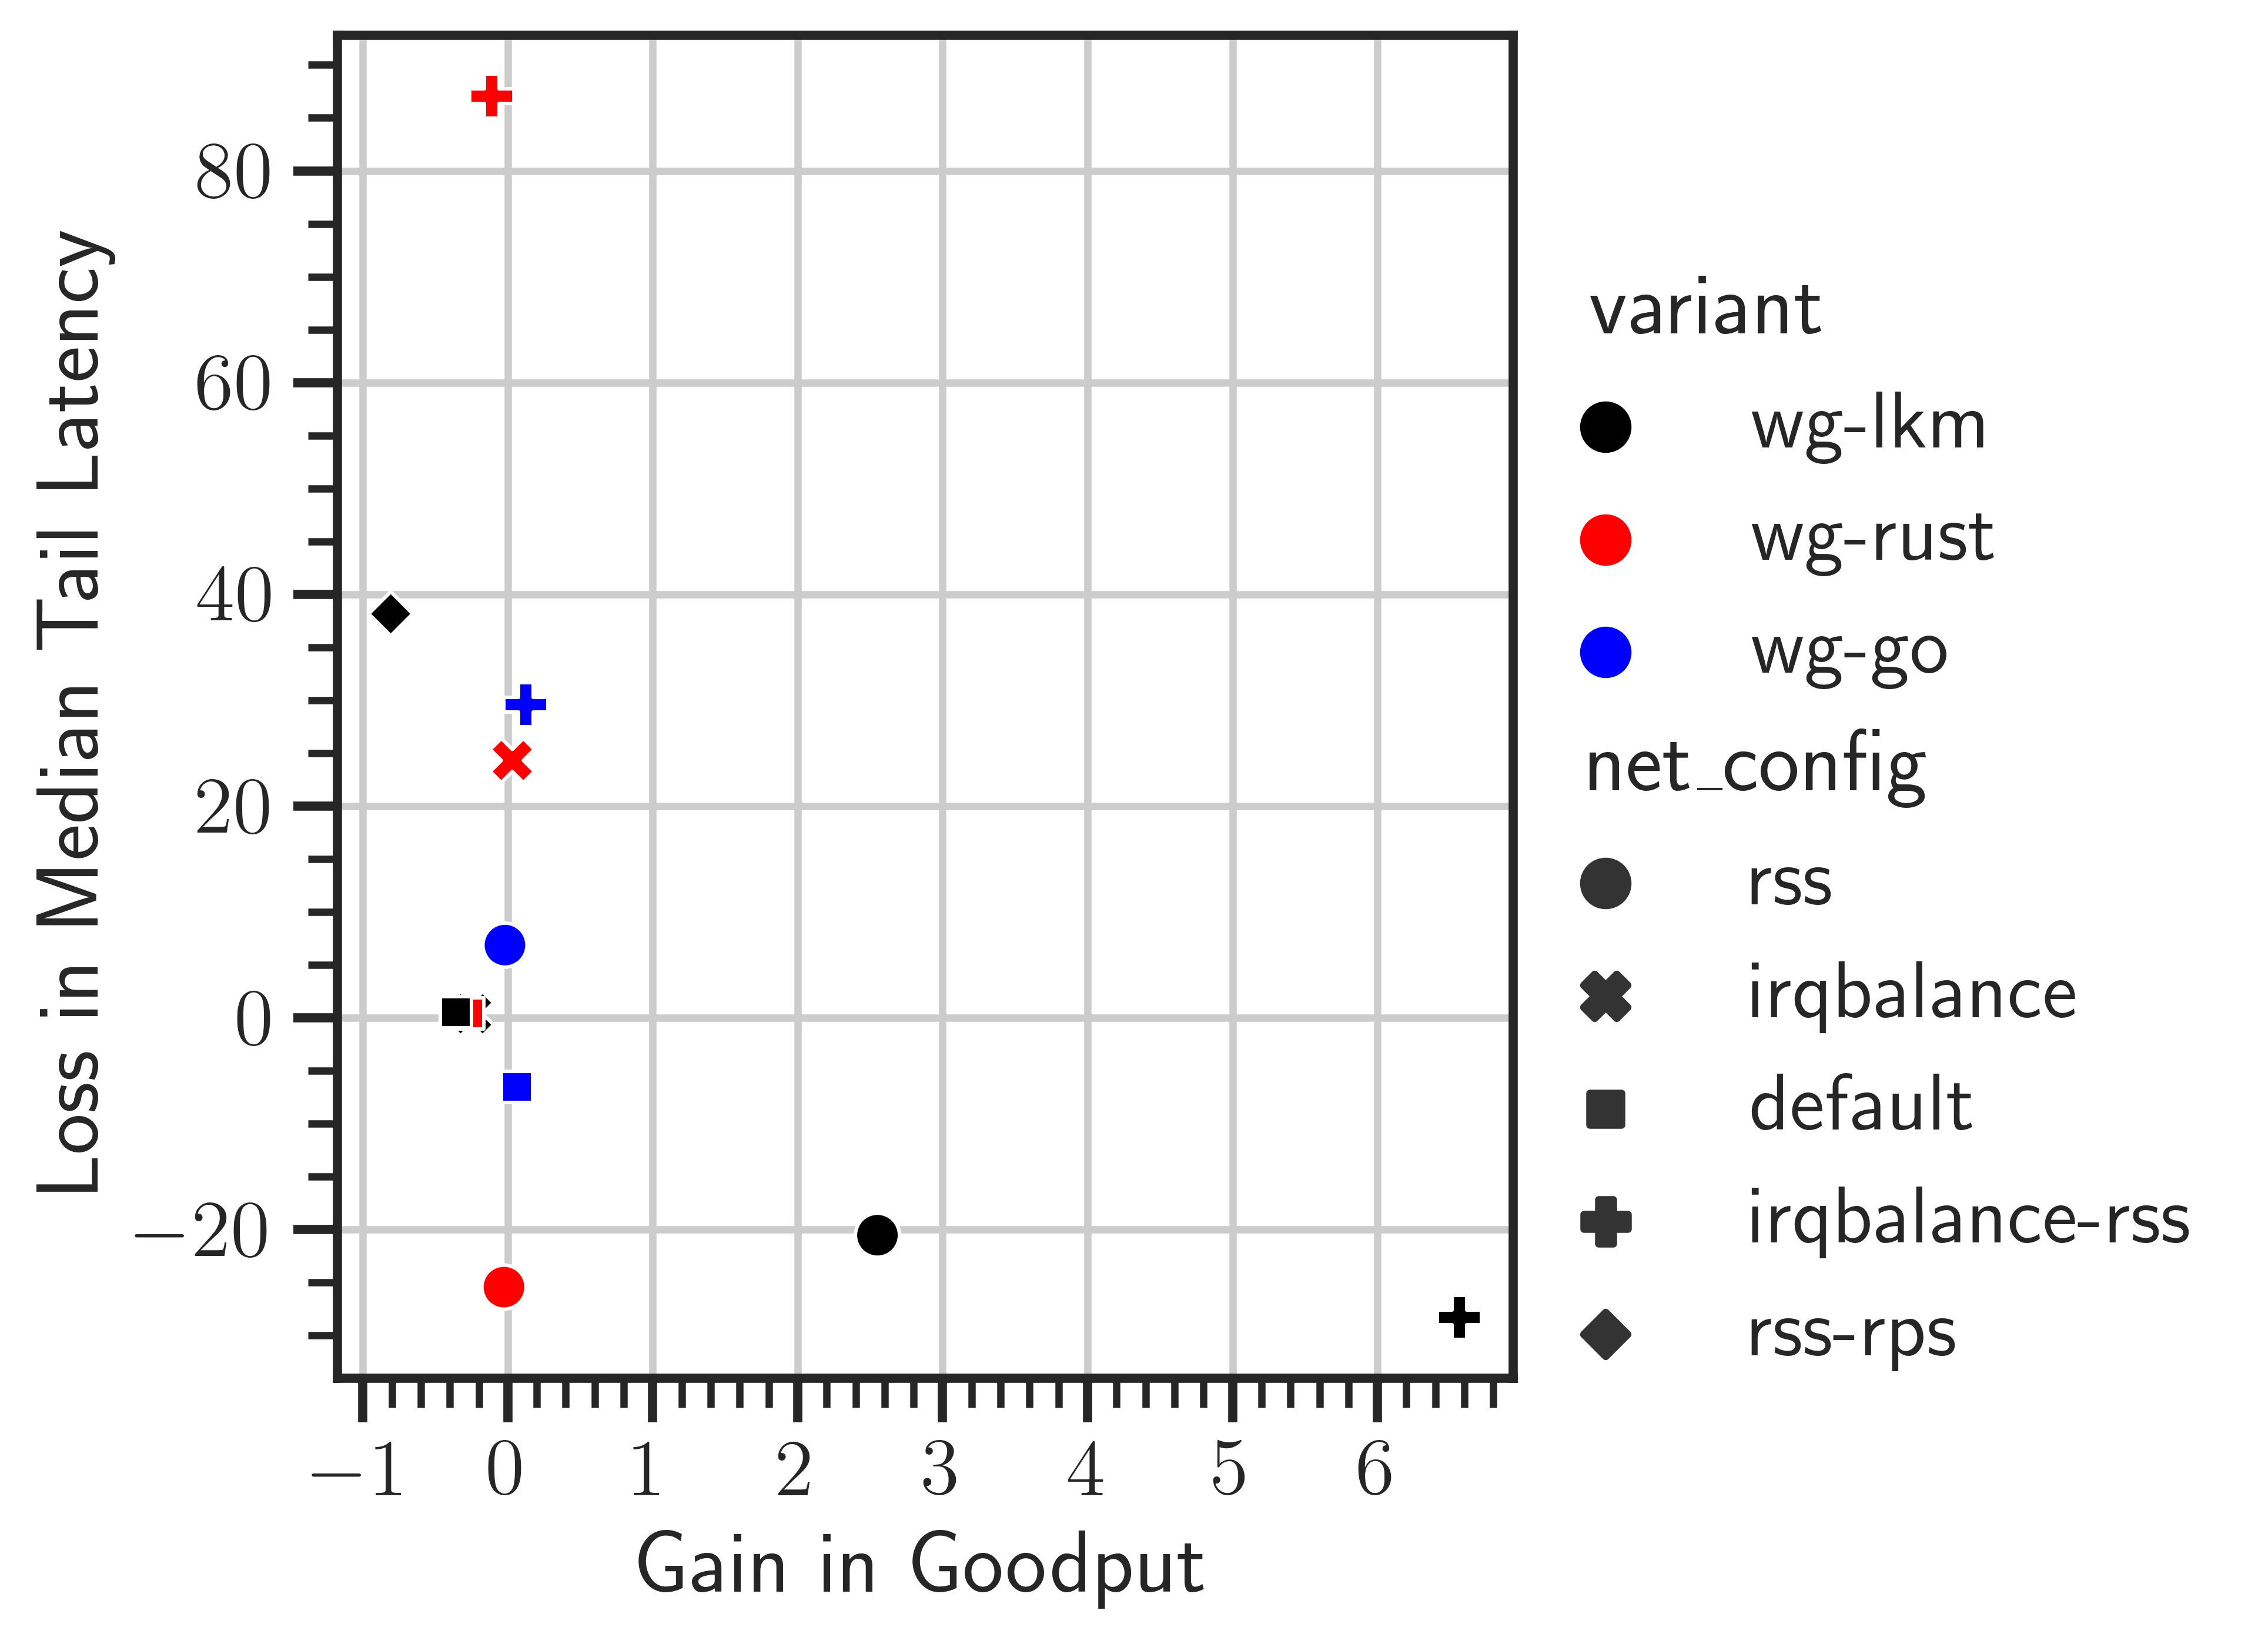

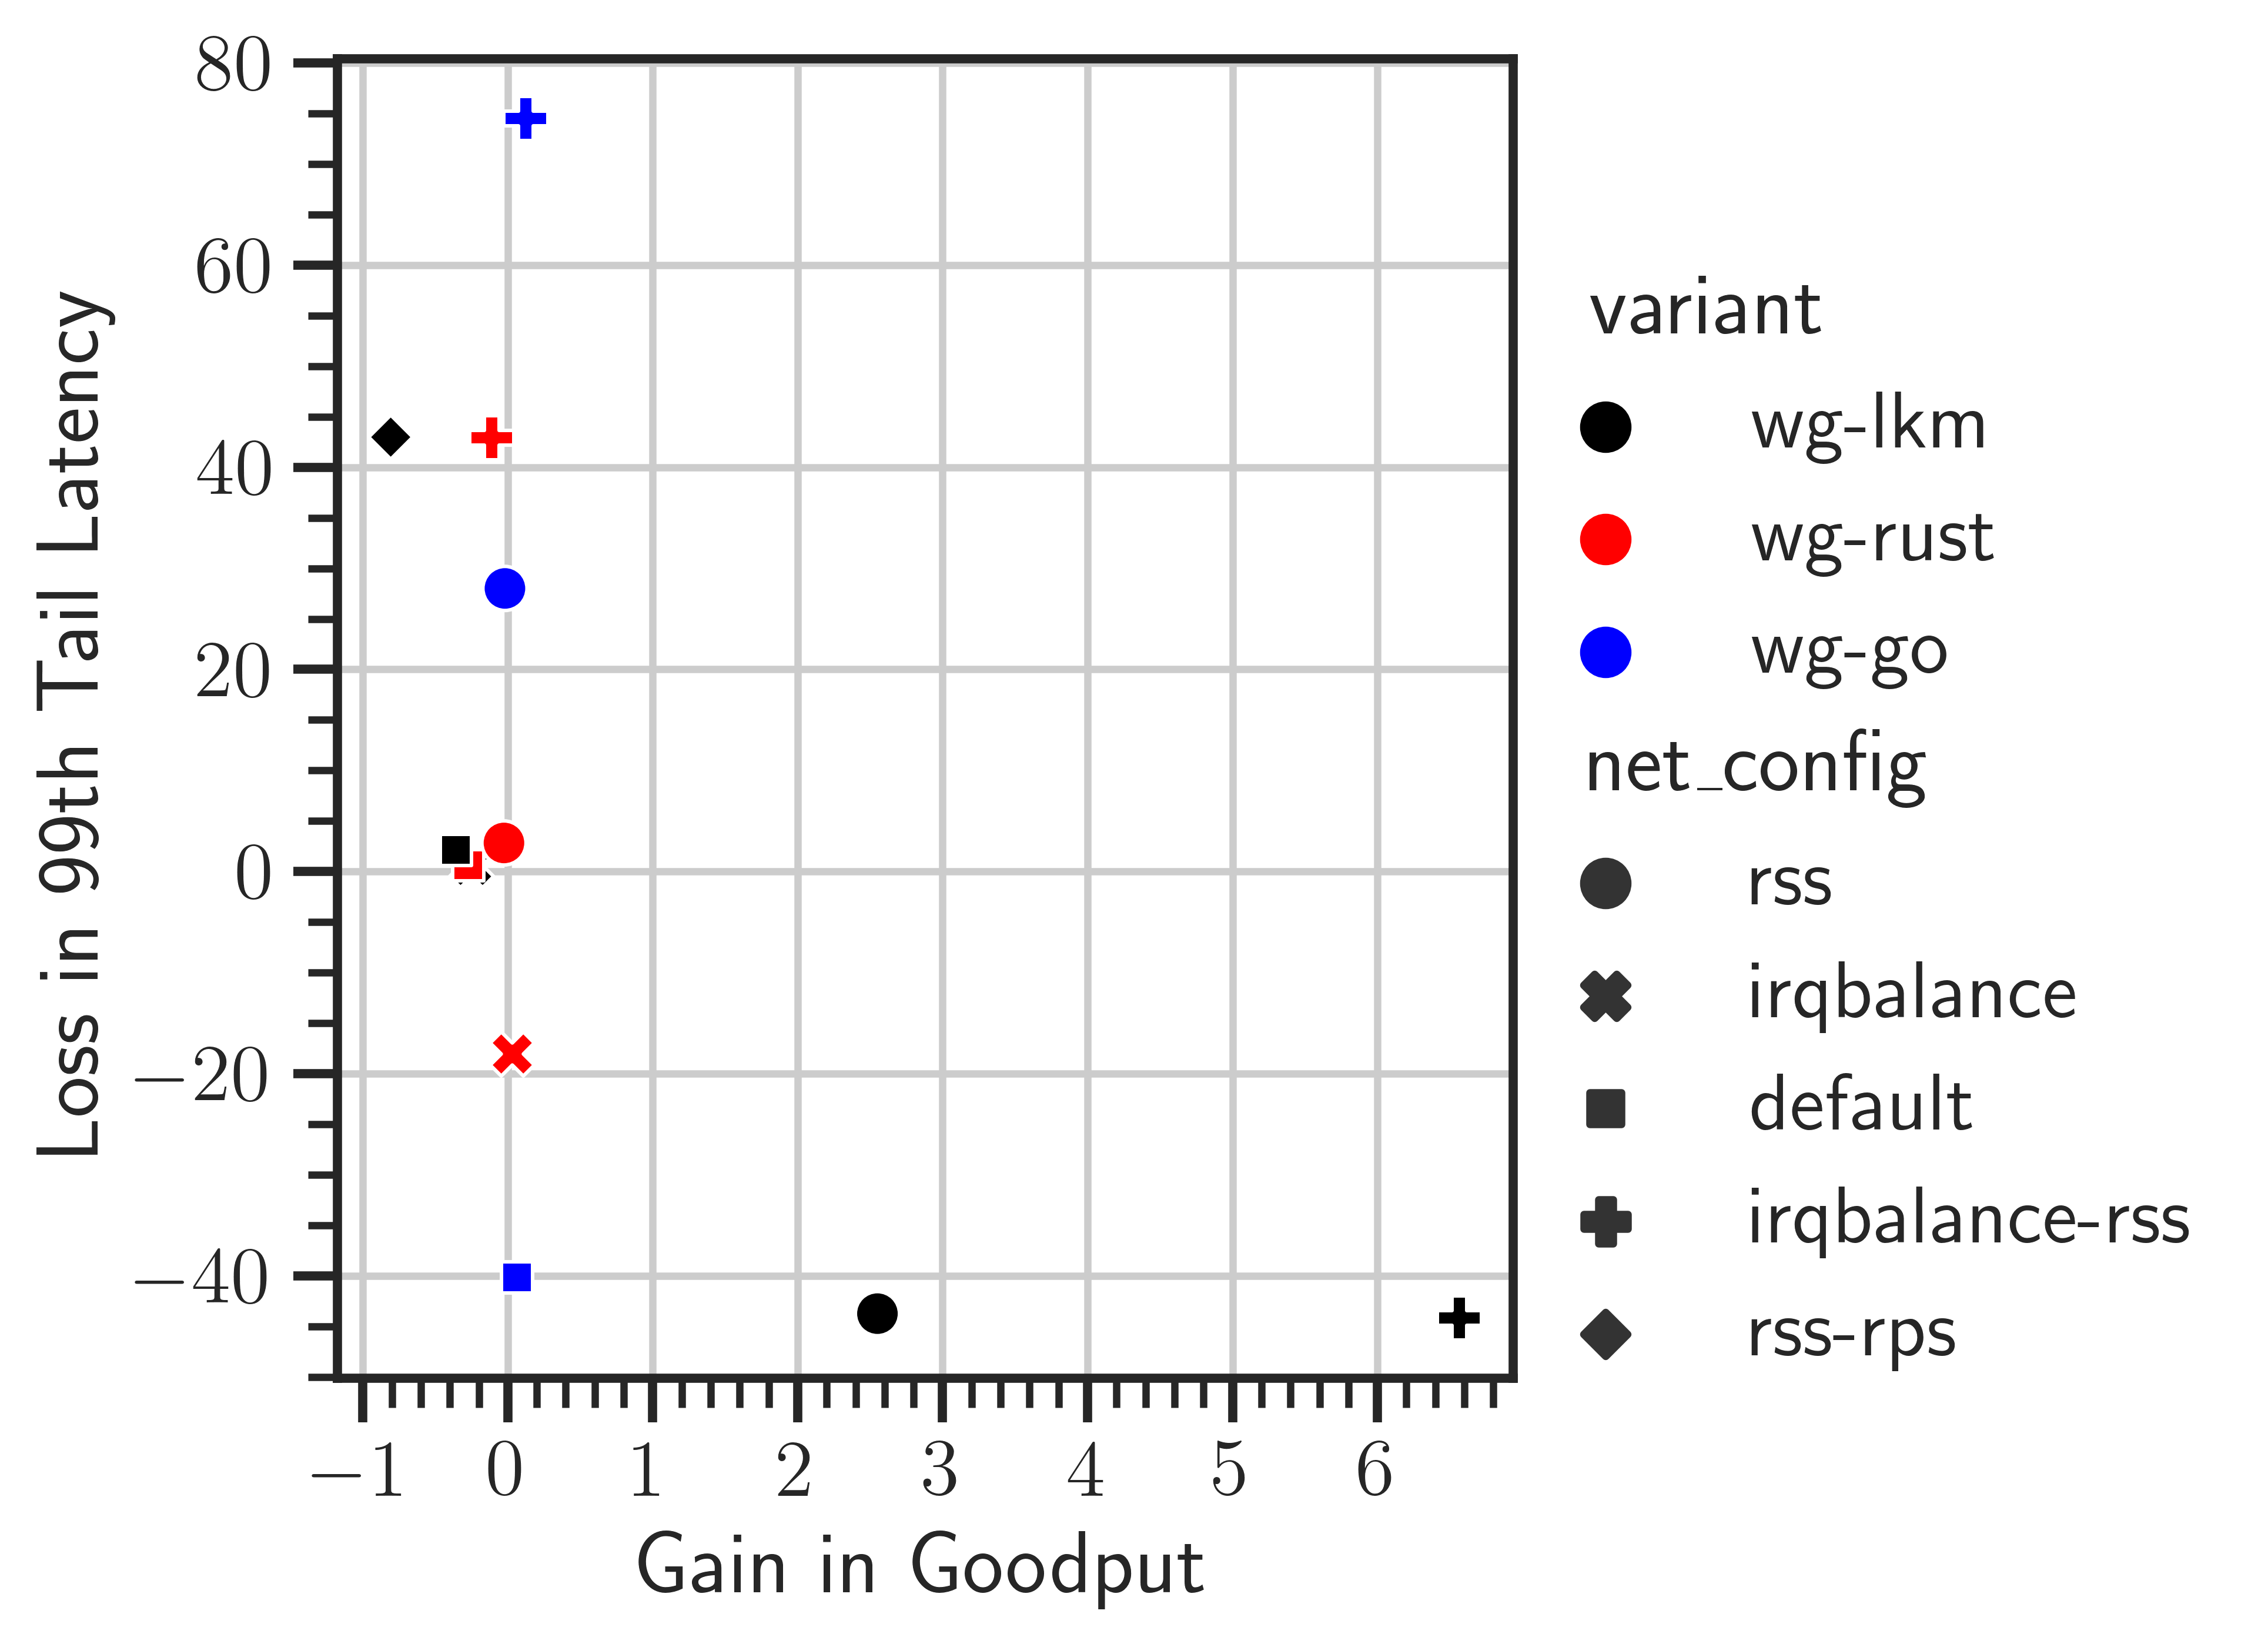

In [128]:
with plt.style.context(['science', 'ieee']):
    sns.set_context("talk")
    sns.set_style('ticks')
    g = sns.relplot(
        data=diff_on_off, x='rxkB/s', y='median',
        hue='variant', 
#         size='cpu', size_order=[18, 36], 
        style='net_config',
#         col='cpu',
        facet_kws={'despine': False}
    )
    g.set(xlabel='Gain in Goodput')
    g.set(ylabel='Loss in Median Tail Latency')
#     for ax in g.axes_dict.values():
#         ax.grid(True)
    g.ax.grid(True)
        
with plt.style.context(['science', 'ieee']):
    sns.set_context("talk")
    sns.set_style('ticks')
    g = sns.relplot(
        data=diff_on_off, x='rxkB/s', y='99th',
        hue='variant', 
#         size='cpu', size_order=[18, 36], 
        style='net_config',
#         col='cpu',
        facet_kws={'despine': False}
    )
    g.set(xlabel='Gain in Goodput')
    g.set(ylabel='Loss in 99th Tail Latency')
#     for ax in g.axes:
#         ax.grid(True)
    g.ax.grid(True)

## CPU Usage x Throughput

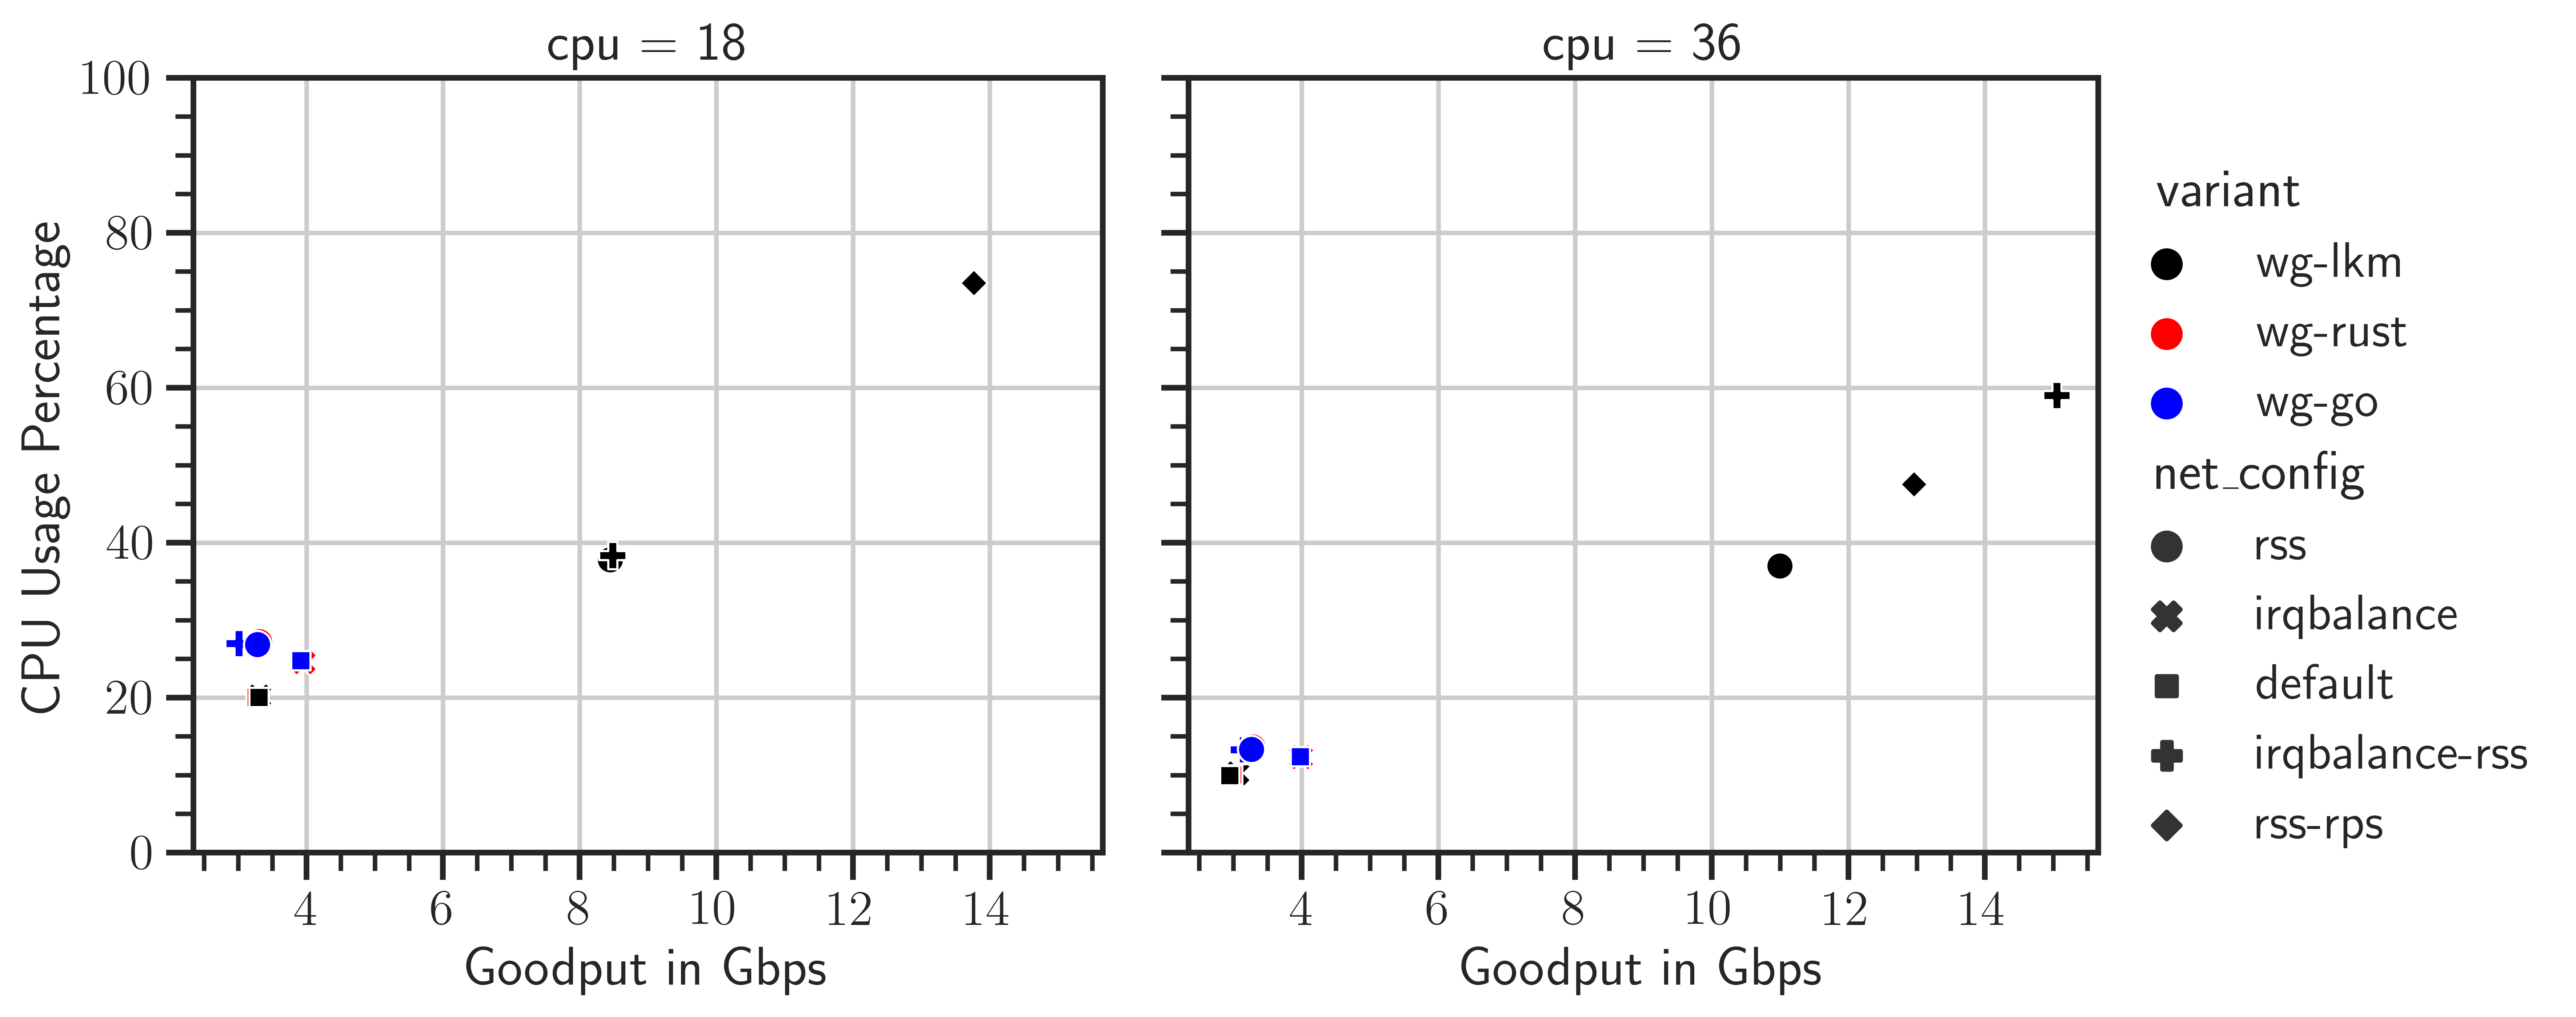

In [129]:
with plt.style.context(['science', 'ieee']):
    sns.set_context("talk")
    sns.set_style('ticks')
    g = sns.relplot(
        data=df_t, x='rxkB/s', y='used',
        hue='variant', 
#         size='cpu', size_order=[18, 36], 
        style='net_config',
        col='cpu',
        facet_kws={'despine': False}
    )
    g.set(xlabel='Goodput in Gbps')
    g.set(ylabel='CPU Usage Percentage')
    g.set(ylim=[0, 100])
    for ax in g.axes_dict.values():
        ax.grid(True)

# with plt.style.context(['science', 'ieee']):
#     sns.set_context("talk")
#     sns.set_style('ticks')
#     g = sns.relplot(
#         data=df_t, x='rxkB/s', y='99th',
#         hue='variant', 
# #         size='cpu', size_order=[18, 36], 
#         style='net_config',
#         col='cpu',
#         facet_kws={'despine': False}
#     )
#     g.set(xlabel='Goodput in Gbps')
#     g.set(ylabel='99th Tail Latency in ms')
#     for ax in g.axes_dict.values():
#         ax.grid(True)
    

## Latency

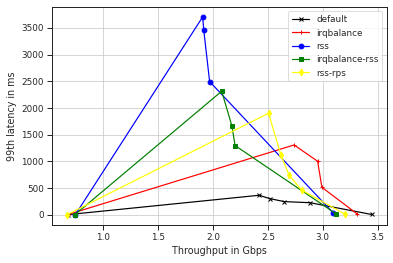

In [1035]:
df_latency, labels = get_dataframes(dirs, kind='latency')
dfs_wg = get_dataframes(dirs, kind='net')[0]
throughput_col = 'rxkB/s'


dfs_lat = [
    pd.merge(lat, wg, on=['cpu', 'client']) for lat, wg in zip(df_latency, dfs_wg)
]

dfs_sorted = [df.sort_values(by=[throughput_col]) for df in dfs_lat]

plot_configs(
    dfs_sorted, x=throughput_col, y='99th',
    xlabel='Throughput in Gbps', ylabel="99th latency in ms",
    labels=labels, ht=False, ylim=None,
)

# CPU

In [25]:
df_global, df_per_core, labels = get_dataframes(dirs, kind='cpu')

## Global CPU usage

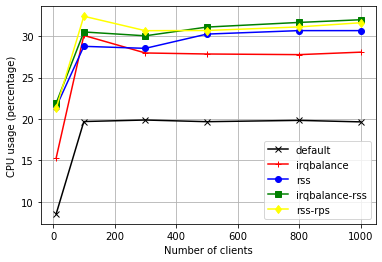

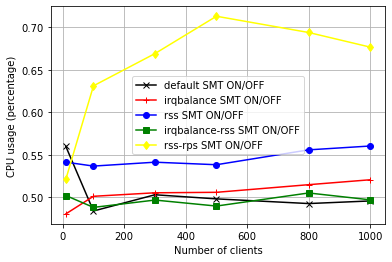

In [26]:
plot_configs(
    df_global, x='client', y='used',
    xlabel='Number of clients', ylabel="CPU usage (percentage)",
    labels=labels, ht=False, ylim=None
)

plot_configs(
    df_global, x='client', y='used',
    xlabel='Number of clients', ylabel="CPU usage (percentage)",
    labels=labels, ht=False, ylim=None, style='diff'
)

## Per core CPU usage

In [27]:
# plot_per_cpu(df_per_core[2], cpu=18)

In [28]:
# for frame, label in zip(df_per_core, labels):
#     print(label)
#     plot_per_cpu(frame, cpu=18)

# Throughput

In [29]:
dfs_wg, dfs_phy, labels = get_dataframes(dirs, kind='net')

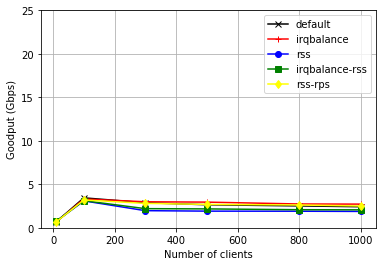

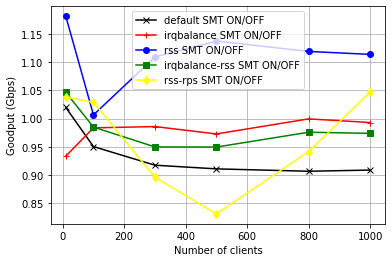

In [30]:
plot_configs(
    dfs_wg, x='client', y='rxkB/s',
    xlabel='Number of clients', ylabel="Goodput (Gbps)",
    labels=configs, ht=False, ylim=[0, 25], style=None
)

plot_configs(
    dfs_wg, x='client', y='rxkB/s',
    xlabel='Number of clients', ylabel="Goodput (Gbps)",
    labels=configs, ht=None, ylim=None, style="diff"
)

In [31]:
dfs, labels = get_dataframes(dirs, kind='latency')

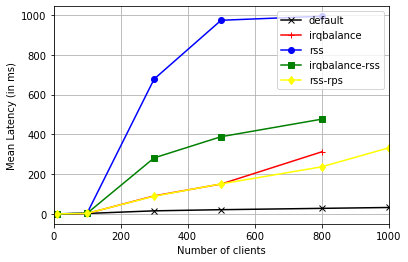

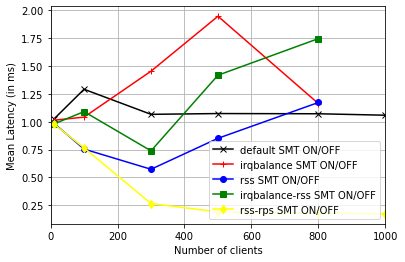

In [32]:
plot_configs(
    dfs, x='client', y='mean',
    xlabel='Number of clients', ylabel="Mean Latency (in ms)",
    labels=labels, ht=False, ylim=None, xlim=[0, 1000]
)

plot_configs(
    dfs, x='client', y='mean',
    xlabel='Number of clients', ylabel="Mean Latency (in ms)",
    labels=labels, ht=True, ylim=None, xlim=[0, 1000], style='diff'
)

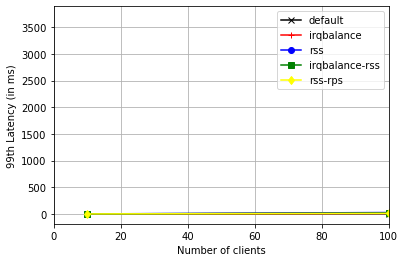

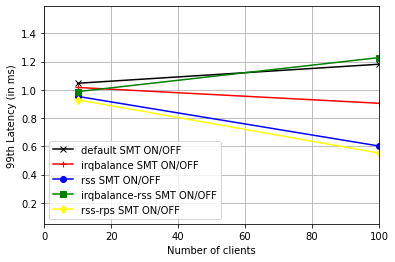

In [33]:
plot_configs(
    dfs, x='client', y='99th',
    xlabel='Number of clients', ylabel="99th Latency (in ms)",
    labels=labels, ht=False, ylim=None, xlim=[0, 100]
)

plot_configs(
    dfs, x='client', y='99th',
    xlabel='Number of clients', ylabel="99th Latency (in ms)",
    labels=labels, ht=False, ylim=None, xlim=[0, 100], style='diff'
)

In [34]:
dfs, labels = get_dataframes(dirs, kind='net-iperf')

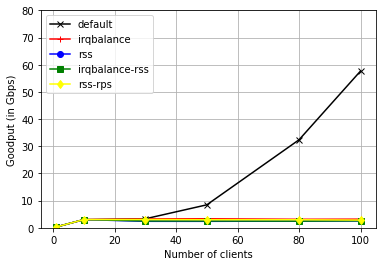

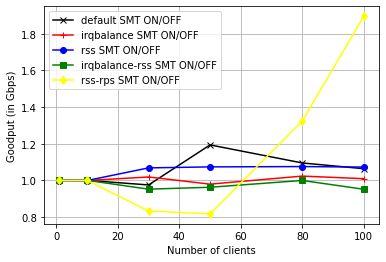

In [35]:
plot_configs(
    dfs, x='client', y='throughput',
    xlabel='Number of clients', ylabel="Goodput (in Gbps)",
    labels=labels, ht=False, ylim=[0, 80],
)

plot_configs(
    dfs, x='client', y='throughput',
    xlabel='Number of clients', ylabel="Goodput (in Gbps)",
    labels=labels, ht=True, ylim=None, style='diff'
)